In [72]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm

from sklearn import preprocessing
import joblib


import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ap_df = pd.read_csv("/data/jdli/gaia/ap17_332904.csv")
print(ap_df.shape)

/tmp/ipykernel_113235/2077694716.py:1: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  ap_df = pd.read_csv("/data/jdli/gaia/ap17_332904.csv")


(332904, 215)


In [3]:
ap_labels = ap_df[['GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PHOT_G_MEAN_MAG', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 
                   'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']]

ap_labels

,GAIAEDR3_SOURCE_ID,TEFF,LOGG,M_H,ALPHA_M,TEFF_ERR,LOGG_ERR,M_H_ERR,ALPHA_M_ERR
0,538028216707715712,3723.9111,0.904598,-0.14768,0.036922,4.060303,0.021523,0.007183,0.004735
1,422596679964513792,6099.7810,3.673970,-0.24510,0.029159,45.847330,0.030661,0.007007,0.011755
2,422596679964513792,6162.0303,3.715561,-0.22151,0.048066,41.753815,0.025935,0.005673,0.009856
3,421077597267551104,5031.2637,3.456132,-0.16008,0.055704,10.145057,0.023554,0.006013,0.006063
4,421086363305436800,4974.6010,2.388251,-0.51314,0.107150,15.310856,0.035517,0.009836,0.010655
...,...,...,...,...,...,...,...,...,...
332899,2011912391134705920,5008.3950,2.480740,-0.41164,0.029987,13.106046,0.030519,0.008129,0.008696
332900,2282127264957087872,4311.3926,1.731429,-0.49909,0.246895,6.555767,0.026187,0.007665,0.006726
332901,1995024236127760000,4954.1700,2.474665,-0.33643,0.088357,15.750314,0.034748,0.009940,0.010114
332902,1998097371124974720,4859.9087,2.480687,-0.22925,0.065434,9.050734,0.024013,0.006350,0.006152


In [4]:
xp_chunks = pd.read_csv(
    "/nfsdata/share/gaiaxp/gdr3_jdli_sid_xp_continuous_mean_spectrum.csv", 
    chunksize=10000, sep="|")

In [ ]:
xp_ap_dfs = pd.DataFrame()

for i,xp_chunk in tqdm(enumerate(xp_chunks)):
    
    xp_ap_df = pd.merge(ap_labels, xp_chunk, 
                        left_on='GAIAEDR3_SOURCE_ID', right_on='source_id')
    xp_ap_dfs = pd.concat((xp_ap_dfs, xp_ap_df), axis='index')
    

611it [11:31,  1.35s/it]

In [ ]:
def recover_coef(series):
    return [list(map(float, s[1:-1].split(','))) for s in series]

coef_names = ['bp_coefficients', 'bp_coefficient_errors', 
              'rp_coefficients', 'rp_coefficient_errors']

for col in coef_names:
    xp_ap_dfs[col] = recover_coef(xp_ap_dfs[col])


In [64]:
xp_coeff_array = np.zeros([4, len(xp_ap_dfs), 55])


for i in range(4):
    xp_coeff_array[i] = np.array([np.array(x) for x in xp_ap_dfs[coef_names[i]].values])


In [65]:
bp_snr = np.abs(xp_coeff_array[0,:,:]/xp_coeff_array[1,:,:])
rp_snr = np.abs(xp_coeff_array[2,:,:]/xp_coeff_array[3,:,:])


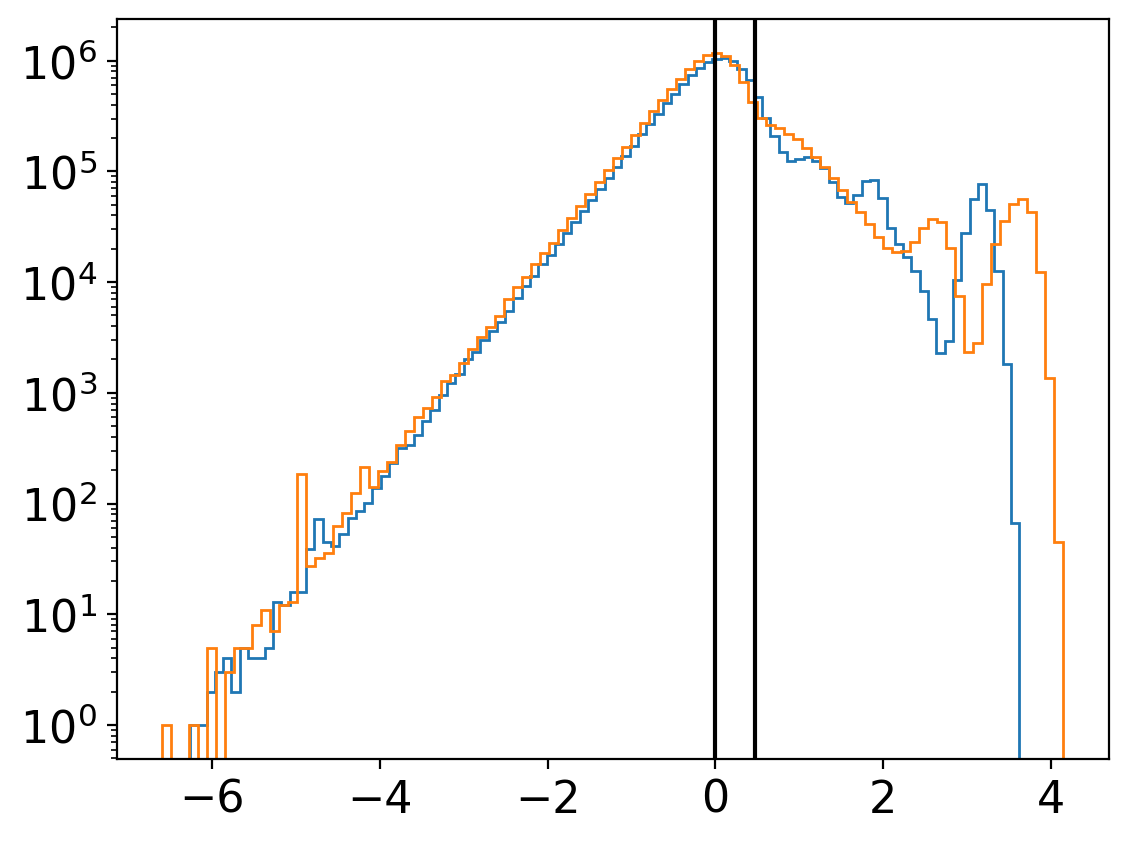

In [66]:
plt.hist(np.log10(bp_snr.flatten()), histtype='step', bins=100, log=True);
plt.hist(np.log10(rp_snr.flatten()), histtype='step', bins=100, log=True);
plt.axvline(x=np.log10(3), c='k')
plt.axvline(x=np.log10(1), c='k')

In [67]:
mask_bp = bp_snr>1
mask_rp = rp_snr>1
gmag_norm = 10**((15.-xp_ap_dfs['GAIAEDR3_PHOT_G_MEAN_MAG'].values)*0.4)

In [74]:
norm_bp = xp_coeff_array[0,:,:]/gmag_norm[:,None]
norm_rp = xp_coeff_array[2,:,:]/gmag_norm[:,None]

scaler_bp = preprocessing.RobustScaler(quantile_range=(25, 75))
scaler_rp = preprocessing.RobustScaler(quantile_range=(25, 75))

norm_bp = scaler_bp.fit_transform(norm_bp)
norm_rp = scaler_rp.fit_transform(norm_rp)

joblib.dump(scaler_bp, '../models/scaler_bp_gmagand_0228.gz')
joblib.dump(scaler_rp, '../models/scaler_rp_gmagand_0228.gz')


['../models/scaler_rp_gmagand_0228.gz']

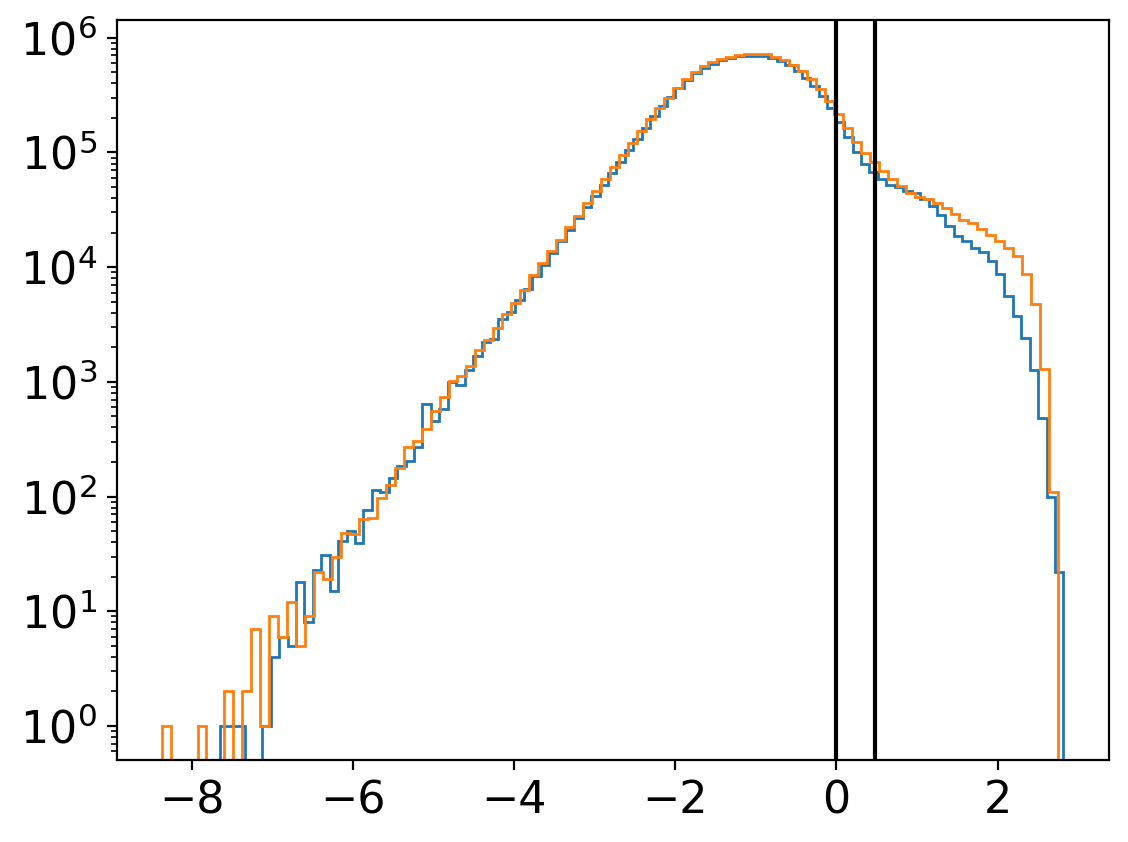

In [84]:
norm_bp_err = xp_coeff_array[1,:,:] / scaler_bp.scale_
norm_rp_err = xp_coeff_array[3,:,:] / scaler_rp.scale_

snr_bp_norm = np.abs(norm_bp/norm_bp_err)
snr_rp_norm = np.abs(norm_rp/norm_rp_err)


plt.hist(np.log10(snr_bp_norm.flatten()[snr_bp_norm.flatten()>0]), histtype='step', bins=100, log=True);
plt.hist(np.log10(snr_rp_norm.flatten()[snr_rp_norm.flatten()>0]), histtype='step', bins=100, log=True);
plt.axvline(x=np.log10(3), c='k')
plt.axvline(x=np.log10(1), c='k')

In [86]:
scaler_labels = preprocessing.RobustScaler(quantile_range=(2.5, 97.5))

labels   = xp_ap_dfs[['TEFF', 'LOGG',  'M_H','ALPHA_M']].values
norm_labels = scaler_labels.fit_transform(labels)

e_labels = xp_ap_dfs[['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']].values
norm_e_labels = e_labels / scaler_labels.scale_

joblib.dump(scaler_labels, '../models/scaler_labels_0228.gz')


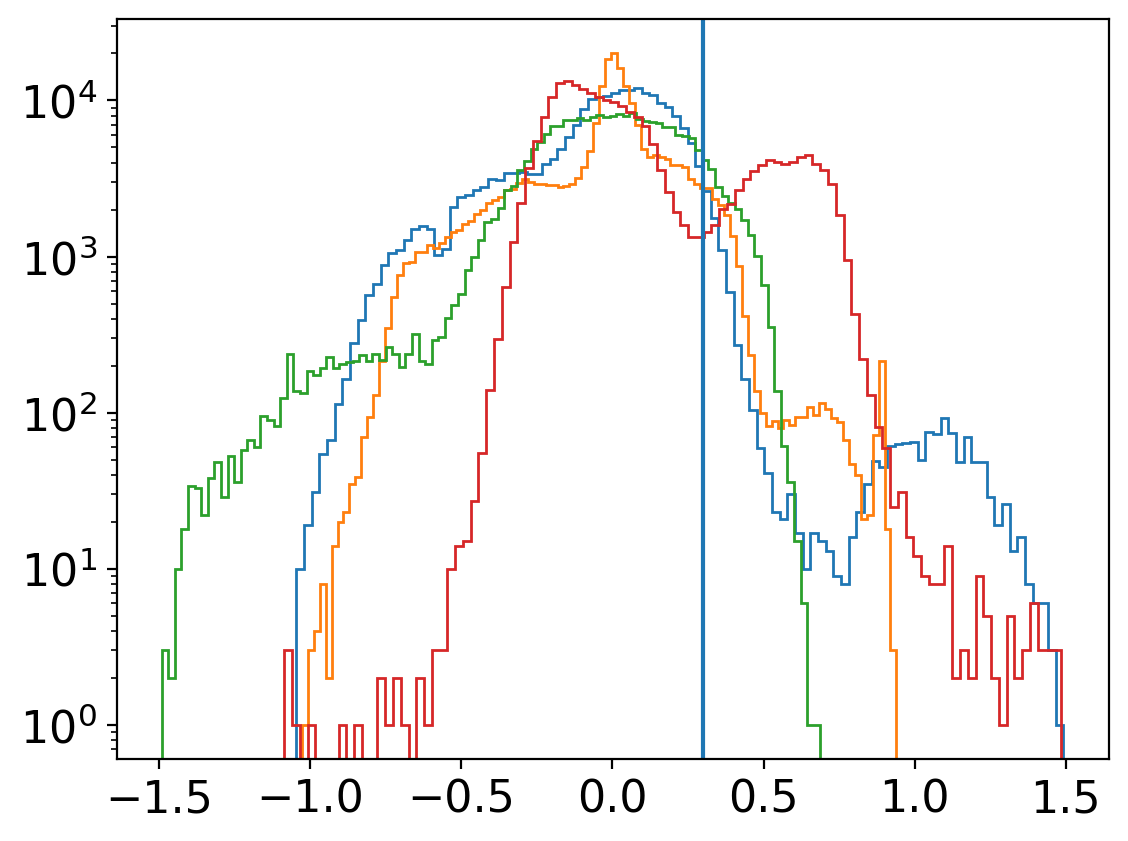

In [124]:
for i in range(4):
    
    plt.hist(norm_labels[:,i], histtype='step', bins=100, log=True)
    
plt.axvline(x=0.3)

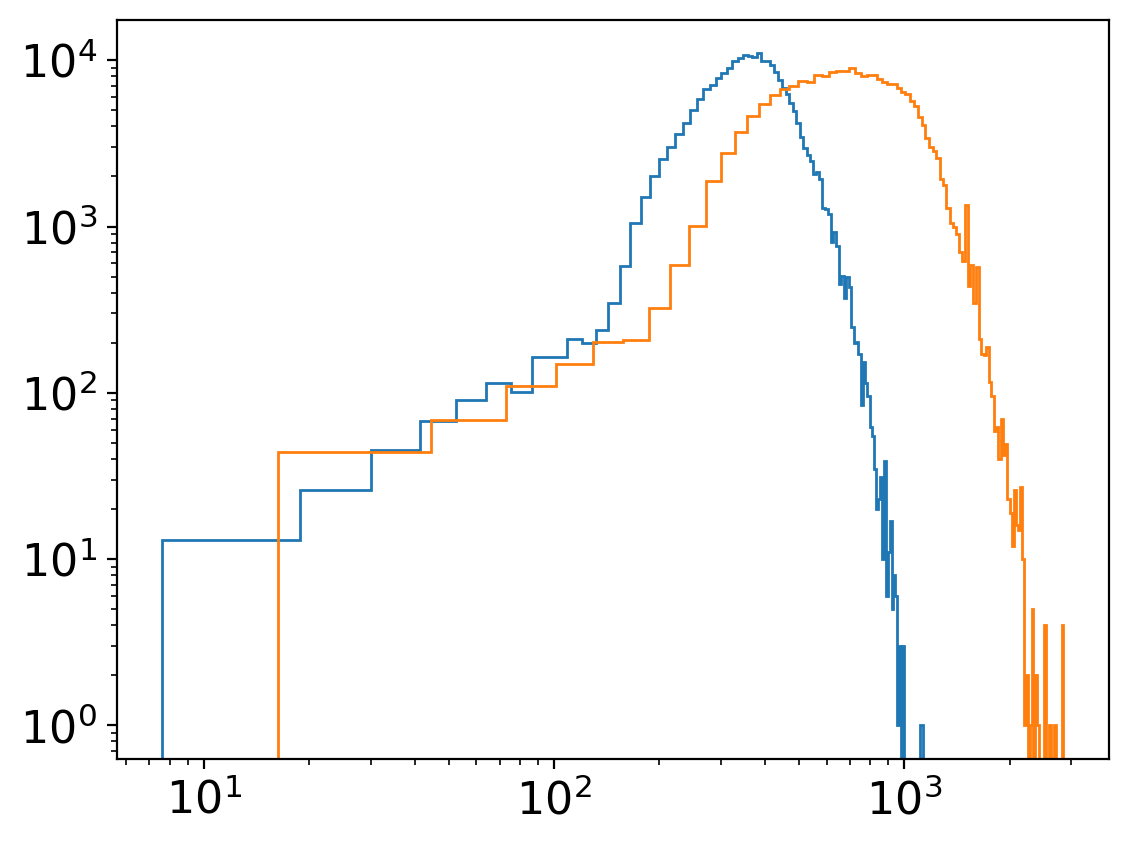

In [106]:
def l2norm(y):
    return np.sqrt(np.sum(y**2, axis=1))


# snr_bp_global = l2norm(norm_bp)/l2norm(norm_bp_err)
# snr_rp_global = l2norm(norm_rp)/l2norm(norm_rp_err)

snr_bp_global = l2norm(xp_coeff_array[0,:,:])/l2norm(xp_coeff_array[1,:,:])
snr_rp_global = l2norm(xp_coeff_array[2,:,:])/l2norm(xp_coeff_array[3,:,:])


plt.hist(snr_bp_global, histtype='step', bins=100, log=True);
plt.hist(snr_rp_global, histtype='step', bins=100, log=True);
plt.xscale('log')

In [122]:
save_data = {
    "x":np.c_[norm_bp, norm_rp],
    # "x_mask":np.c_[bp_snr>1, rp_snr>1],
    "x_mask":np.c_[bp_snr<1, rp_snr<1],
    "y":norm_labels, 
    "e_y":norm_e_labels, 
    "source_id":xp_ap_dfs['source_id'].values
}

data_dir = "/data/jdli/gaia/"
fname = "ap_xp_233985.npy"
np.save(data_dir+fname, save_data)

In [125]:
!ls /nfsdata/share/gaiaxp/


gdr3_jdli_sid_xp_continuous_mean_spectrum.csv
xmatch_lamost_dr8_v2_0_lrs_gaia_dr3_xp_continuous_mean_spectrum.csv
